# Assignment 5

Explore embeddings and CNN

Using tweeter dataset ( https://www.kaggle.com/utathya/sentiment-analysis-of-imdb-reviews/data) and already existing splitting on train/test sets, develop a model for sentiment analysis.  
Your quality metric is crossentropy (`sklearn.metrics.log_loss`, `torch.nn.CrossEntropy`)  

Your model should be based on CNN and written in pytorch `torch.nn.Conv1d`.

Explore 3 ways, which of them has better perfomance on test set?:
1. Using pretrained word embeddings with frozen weights. `torch.nn.Embedding.from_pretrained(embed_matrix, frozen=True)`.
You can download any pretrained embeddings you like.
2. Train embeddings yourself, initializing from pretrained weights. `torch.nn.Embedding.from_pretrained(embed_matrix, frozen=False)`
3. Train embeddings yourself with random initialization `torch.nn.init.uniform_(nn.Embeddings.weights)`

Experiment with model arhitecture (as bonus):
1. activation functions RELU, ELU, etc `torch.nn.functional.relu, torch.nn.functional.elu`  
1. Stack layers
1. max or average pooling (`torch.nn.functional.max_pool1d, torch.nn.functional.avg_pool1d`)
1. Dropout


Other requirements:
1. Your training routine should use any learning scheduler (torch.nn.optim.lr_scheduler).  
Plot current learning rate against number of epochs, e.g. `tt.optim.Adam.param_groups[0]['lr']`.  

1. Your training routine should use early stopping on validation dataset
Use hold out validation scheme in your experiments.

1. You should use torchtext for parsing 

**Note**:
This assignment has no baseline. Instead, **validation curves** for explored architectures are expected.  
Validation curve is plot of model test score against model hyperparameter value.  
example (https://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html) . 
Though, using `sklearn.model_selection.validation_curve` is not necessary.  







In [1]:
import pandas as pd
import numpy as np
from sklearn.externals import joblib
import nltk
import gensim
import spacy

from sklearn import metrics

import torch as tt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext.data import Field, LabelField, BucketIterator, TabularDataset, Iterator



SEED = 42
np.random.seed(SEED)

In [2]:
spacy_en = spacy.load('en')

def tokenizer(text): # create a tokenizer function
    return [tok.text for tok in spacy_en.tokenizer(text) if tok.text.isalpha()]

In [3]:
df = pd.read_csv(r'imdb_master.csv', encoding='latin-1', index_col = 0)

In [4]:
df.head()

,type,review,label,file
0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [5]:
df[df['type'] == 'test'].to_csv(r'test.csv', encoding='utf-8')
df[df['type'] == 'train'].to_csv(r'train.csv', encoding='utf-8')

In [6]:
classes={
    'neg':0,
    'unsup':1,
    'pos':2
}

TEXT = Field(include_lengths=True, batch_first=True, 
             tokenize=tokenizer,
             eos_token='<eos>',
             lower=True,
             stop_words=nltk.corpus.stopwords.words('english'))
LABEL = LabelField(dtype=tt.int64, use_vocab=True, preprocessing=lambda x: classes[x])

train = TabularDataset('train.csv', format='csv',
                         fields=[(None, None), (None, None),('text', TEXT), ('label', LABEL), (None, None)], 
                         skip_header=True)

test = TabularDataset('test.csv', format='csv',
                         fields=[(None, None), (None, None),('text', TEXT), ('label', LABEL), (None, None)], 
                         skip_header=True)

In [7]:
TEXT.build_vocab(train, min_freq=5, vectors="glove.6B.100d")
len(TEXT.vocab.itos)

46317

In [8]:
TEXT.vocab.itos[:10]

['<unk>',
 '<pad>',
 '<eos>',
 'movie',
 'film',
 'one',
 'like',
 'good',
 'would',
 'even']

In [9]:
LABEL.build_vocab(train)

In [10]:
train, valid = train.split(0.7, stratified=True)

In [11]:
class CNN(nn.Module):
    
    def __init__(self, vocab_size, embed_size, embed_matrix, hidden_size, kernels, mode):
        super(CNN, self).__init__()
        if mode == 'pretrained':
            self.embedding = nn.Embedding.from_pretrained(embed_matrix, freeze=True)
        elif mode == 'weights':
            self.embedding = nn.Embedding.from_pretrained(embed_matrix, freeze=False)
        elif mode == 'random':
            self.embedding = nn.Embedding.from_pretrained(nn.init.uniform_(tt.ones((vocab_size,100))), freeze=False)
            
        self.convs = nn.ModuleList([nn.Conv1d(embed_size, hidden_size, k, padding=5) for k in kernels])
        
        self.fc = nn.Linear(hidden_size * len(kernels), 3)
        
    def forward(self, x):
        
        x = self.embedding(x)
        x = x.transpose(1,2)
        
        concatenated = []
        for conv in self.convs:
            z = conv(x)
            z = F.avg_pool1d(z, kernel_size=z.size(2))
            z = z.squeeze(2)
            concatenated.append(z)
            
        x = tt.cat(concatenated, 1)
        x = self.fc(x)
        return x

In [24]:
class MyModel:
    def __init__(self, model, train_iterator, test_iterator, valid_iterator):
        self.model = model
        self.train_iterator = train_iterator
        self.test_iterator = test_iterator
        self.valid_iterator = valid_iterator
        
        self.optimizer = optim.Adam(self.model.parameters())
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, patience=5, verbose=True, cooldown=5)
        self.criterion = nn.CrossEntropyLoss()
        
    def train(self, n_epochs):
        min_loss = np.inf
        early_stop = 0
        learning_rate = []
        
        for i in range(n_epochs):
            train_loss = 0
            
            for batch in self.train_iterator:
                self.optimizer.zero_grad()
                y_pred = self.model.forward(batch.text[0])
                loss = self.criterion(y_pred, batch.label)
                train_loss += loss
                loss.backward()
                self.optimizer.step()
                
            train_loss = train_loss / len(self.train_iterator)         
            test_loss = 0
            
            with tt.no_grad():
                for batch in self.test_iterator:
                    test_pred = self.model.forward(batch.text[0])
                    loss = self.criterion(test_pred, batch.label)
                    test_loss += loss
            
            test_loss = test_loss / len(self.test_iterator)           
            self.scheduler.step(test_loss)
            learning_rate.append(self.optimizer.param_groups[0]['lr'])
            
            if test_loss < min_loss:
                min_loss = test_loss
                early_stop = 0
            elif early_stop < 10:
                early_stop += 1
            else:
                break
                
            print('Epoch %s: train loss - %s, test_loss - %s' % (str(i), float(train_loss), float(test_loss)))
                
        return learning_rate
    
    def evaluate(self, mode):
        total_loss = 0
        
        with tt.no_grad():
            for batch in self.valid_iterator:
                y_pred = self.model.forward(batch.text[0])
                loss = self.criterion(y_pred, batch.label)
                total_loss += loss
                
        print('%s loss: %s' % (mode, float(total_loss / len(self.valid_iterator))))
                    
        return float(total_loss / len(self.valid_iterator))

In [22]:
tt.cuda.empty_cache()

batch_size = 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train, valid, test),
    batch_sizes=(batch_size, batch_size, batch_size),
    shuffle=True,
    sort_key=lambda x: len(x.text)
)

In [26]:
losses = list()
lr_all = list()

for mode in ['random', 'pretrained', 'weights']:
        
    model = CNN(vocab_size=len(TEXT.vocab.vectors),
                     embed_size=100,
                     hidden_size=128,
                     kernels=[2,3,4,5],
                     embed_matrix=TEXT.vocab.vectors,
                     mode=mode)

    trainer = MyModel(model, train_iterator, test_iterator, valid_iterator)
    lr = trainer.train(5)
    lr_all.append(lr)
    
    test_loss = trainer.evaluate(mode)
    losses.append(test_loss)
    
    print(f' Test Loss: {test_loss:.3f}')

Epoch 0: train loss - 0.8637376427650452, test_loss - 1.2578479051589966
Epoch 1: train loss - 0.7609472870826721, test_loss - 1.6310479640960693
Epoch 2: train loss - 0.7008785009384155, test_loss - 1.417634129524231
Epoch 3: train loss - 0.6330395340919495, test_loss - 2.08035945892334
Epoch 4: train loss - 0.5702682137489319, test_loss - 3.4332408905029297
random loss: 1.5903353691101074
 Test Loss: 1.590
Epoch 0: train loss - 0.8291342854499817, test_loss - 1.3246499300003052
Epoch 1: train loss - 0.8143865466117859, test_loss - 1.5120059251785278
Epoch 2: train loss - 0.8130980730056763, test_loss - 1.6302101612091064
Epoch 3: train loss - 0.8101744651794434, test_loss - 1.824271559715271
Epoch 4: train loss - 0.8111647963523865, test_loss - 1.690543293952942
pretrained loss: 0.9871635437011719
 Test Loss: 0.987
Epoch 0: train loss - 0.7934651970863342, test_loss - 1.2576520442962646
Epoch 1: train loss - 0.6382262110710144, test_loss - 2.31744647026062
Epoch 2: train loss - 0.484

Text(0,0.5,'L.Rate')

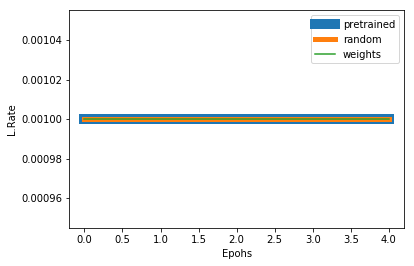

In [56]:
plt.plot(range(0, len(lr_all[1])), lr_all[1], label = 'pretrained', linewidth=10)
plt.plot(range(0, len(lr_all[0])), lr_all[0], label = 'random', linewidth=5)
plt.plot(range(0, len(lr_all[2])), lr_all[2], label = 'weights')

plt.legend()

plt.xlabel('Epohs')
plt.ylabel('L.Rate')

Text(0,0.5,'Test Loss')

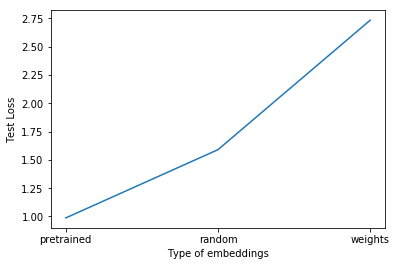

In [57]:
plt.plot(['pretrained', 'random', 'weights'], [losses[1], losses[0], losses[2]])
plt.xlabel('Type of embeddings')
plt.ylabel('Test Loss')